# Project EDA and Data Pre-processing

## Set-up

In [3]:
import os
from os.path import join  
import requests
import zipfile
import tarfile
import shutil
import random
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

### GitHub Integration

In [4]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [5]:
# Integrate GitHub

# each group member should add their own ENV_PATH here
# comment out other people's ENV_PATHs
# Steve:
# ENV_PATH = "/content/drive/MyDrive/adv_practical_data_science/local-repo/AC215_KKST/.env"
# Matt:
# Shih-ye:
# Al:
# Ed:
ENV_PATH = "/content/drive/MyDrive/AC215_ED/AC215_KKST/.env"

# load environment variables
with open(ENV_PATH) as env:
  env_text = env.read()
env_list = env_text.split("\n")
PROJECT_PATH = env_list[0]
GIT_PATH = env_list[1]
EMAIL = env_list[2]
GIT_USERNAME = env_list[3]

# expand paths
REPO_PATH = PROJECT_PATH + '/AC215_KKST'
NOTEBOOK_DIR_PATH = REPO_PATH + '/notebooks'
DATA_PATH = REPO_PATH + '/data'

# change directory to the local repo's notebook folder
%cd '{NOTEBOOK_DIR_PATH}'

/content/drive/MyDrive/AC215_ED/AC215_KKST/notebooks


#### Cells for updating local/remote repos

In [6]:
# This will update your local repo with work other group member's have done on the project so you can build on their work.
!git pull

Already up to date.


In [7]:
# check statuses of the files you changed
# this will give a list of files currently in the "head"
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   EDA.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../data/flickr/

no changes added to commit (use "git add" and/or "git commit -a")


In [8]:
# add files you changed to the head
# this is where you tell Git which files you changed that you want to update your local repo with

# add all files in your local repo to the head
!git add .

# add all files you changed to the head
#!git add -u

# add files by name that you want to add to the head
#!git add {filename1}

# check statuses of the files you changed
# this will give a list of files currently in the "head"
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   EDA.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   EDA.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../data/flickr/



In [9]:
# commit the changes in the head to your local repo
# note if your message is too long the the commit will not work, keep it under 50 characters.
!git commit -m "updated caption EDA"
!git config --global user.email "ed.bayes@mde.harvard.edu"
!git config --global user.name "ebayes"

[main df297cd] updated caption EDA
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/EDA.ipynb (96%)


In [10]:
# push the changes in your local repo to the group's remote repo develop branch
#!git push origin develop

# push the changes in your local repo to the group's remote repo master branch
# note that only changes which have been thorough tested and validated should be committed to the master branch
!git push origin

# you can also create additional branches for the remote repo as desired

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 3.87 KiB | 792.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/skgithub14/AC215_KKST.git
   dd40cde..df297cd  main -> main


### Verify Set-up

In [11]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
!nvidia-smi

Tue Oct 26 04:51:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    74W / 149W |    123MiB / 11441MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Utilities

In [13]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    img_path = FIMAGES + '/' + item[0]
    image = cv2.imread(img_path)
    data_list_with_metrics.append((img_path,image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'path': data_list_with_metrics[:, 0],
    'height': data_list_with_metrics[:, 1],
    'width': data_list_with_metrics[:, 2],
    'size': data_list_with_metrics[:, 3],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## Data Sets

### Download and Read In

In [14]:
# FLICKR data
# download
start_time = time.time()
download_file("https://storage.googleapis.com/ac215-project/flickr_data.zip", base_path=DATA_PATH + '/flickr', extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

# read-in
FLICKR_PATH = DATA_PATH + '/flickr'
fcaps = pd.read_csv(os.path.join(FLICKR_PATH,"captions.txt"))

Download execution time (mins) 2.0111377120018004


### Explore Data Shape

In [15]:
# explore the captions
print("Number of rows:",fcaps.shape[0])
print("Unique image names:",len(pd.unique(fcaps['image'])))
print("Unique captions:",len(pd.unique(fcaps['caption'])))
print("Unique rows:",len(fcaps.value_counts()))
print("Head:")
fcaps.head()

Number of rows: 40455
Unique image names: 8091
Unique captions: 40201
Unique rows: 40445
Head:


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [16]:
# explore the images
FIMAGES = FLICKR_PATH + '/Images'
print("Counting all .png files in: " + FIMAGES)
x=0
for files in os.listdir(FIMAGES):
    if files.endswith('.jpg'):
        x+=1
print(x)

Counting all .png files in: /content/drive/MyDrive/AC215_ED/AC215_KKST/data/flickr/Images
8091


### Analyzing Captions

In [17]:
#pre processing

#lemmatize captions with stopwords removal
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
fcaps['lemmatized'] = fcaps['caption'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# calcaulate length of captions
fcaps['word_count'] = fcaps['caption'].apply(lambda x: len(str(x).split()))
fcaps['letter_count'] = fcaps['caption'].astype(str).apply(len)

# sentiment analysis
from textblob import TextBlob
fcaps['polarity'] = fcaps['caption'].map(lambda text: TextBlob(text).sentiment.polarity)

# fcaps.head()

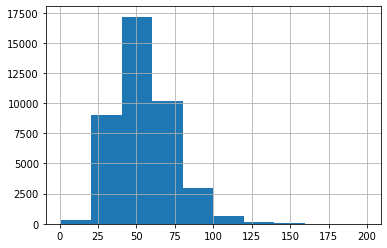

In [31]:
# captions are generally between 25 and 100 characters
fcaps['caption'].str.len().hist()

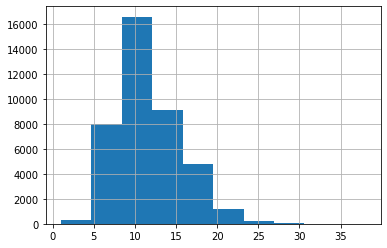

In [33]:
# and 5 to 20 words
fcaps['word_count'].hist()

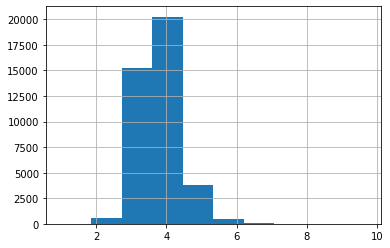

In [34]:
# with an average word length of 3 to 4 characters
fcaps['caption'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


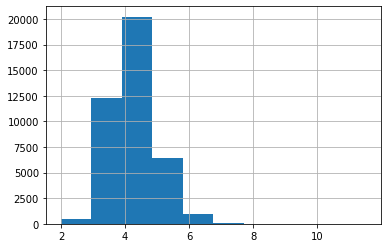

In [35]:
# removing stopwords, this is not dissimilar
fcaps['lemmatized'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

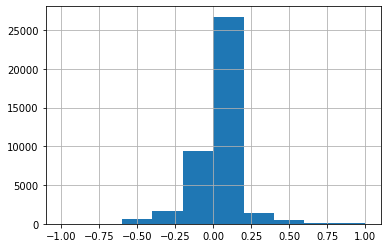

In [32]:
# and the majority of the sentiment polarity scores cluster around zero meaning most are pretty neutral
fcaps['polarity'].hist()

In [46]:
# breaking down captions into individual words

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
corpus=[]
new= fcaps['caption'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

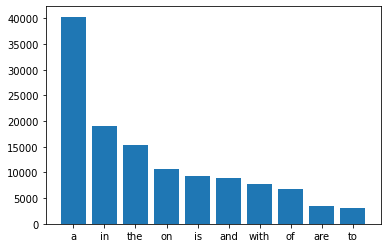

In [50]:
# we can plot top stopwords like 'a', 'in', and 'the'

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(fcaps['caption'])

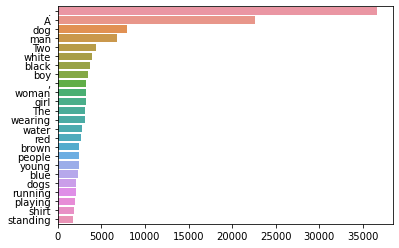

In [51]:
# and plotting lemmatized words removing stopwords shows the top words are 'dog' and 'man'

from collections import Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

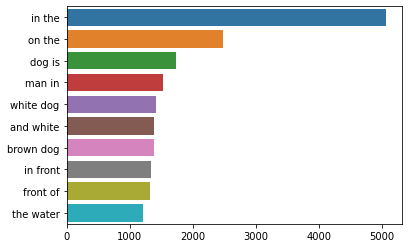

In [56]:
# digging deeper we can use ngram exploration to look at which pairs of words come up the most

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(fcaps['caption'],2)

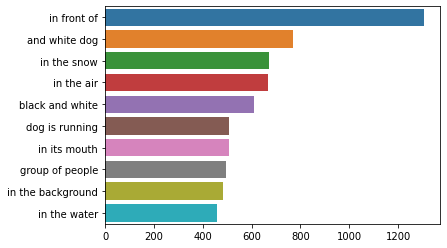

In [57]:
# and which trigrams

top_tri_grams=get_top_ngram(fcaps['caption'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

### Sample Images

In [ ]:
# retrieve an image and caption
this_img = fcaps.iloc[1][0]
print(this_img)
print(fcaps.iloc[1][1])
image = cv2.imread(FIMAGES + '/' + this_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# retrieve a sample of images and captions
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(pd.unique(fcaps['image']))-1, size=10)

fig = plt.figure(figsize=(20,20))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(5,2,i+1)
    axs.set_title(fcaps.iloc[img_idx][1])
    # Read image
    image = cv2.imread(FIMAGES + '/' + fcaps.iloc[img_idx][0])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### Data Set Metrics

In [ ]:
# Compute dataset metrics
# only do this for unique images (each image has multiple possible captions)
u_images = pd.unique(fcaps['image'])
u_images_df = pd.DataFrame({
    'image': u_images,
    'ind': range(0,len(u_images))
    })
u_images_df["ind"] = u_images_df["ind"].astype(str)
u_images_list = u_images_df.values.tolist()
compute_dataset_metrics(u_images_list)

## Build Data Pipelines

### Pre-process

In [ ]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

all_captions = [itm[1] for itm in fcaps_list]

tokenizer.fit_on_texts(all_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(data_y)

print("Example tokenized caption:", train_seqs[0])

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)
print("Max caption length:", max_length)

### Split the Data

In [ ]:
# Download image files
IMAGE_PATH = FLICKR_PATH + '/Images'

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in fcaps_list:
  caption = f"<start> {val[1]} <end>"
  image_path = IMAGE_PATH + '/' + val[0]
  image_path_to_caption[image_path].append(caption)

# randomly shuffle the image order
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
image_paths_order = image_paths.copy()

# create x and y data
data_y = []
data_x = []
for image_path in image_paths_order:
  caption_list = image_path_to_caption[image_path]
  data_y.extend(caption_list)
  data_x.extend([image_path] * len(caption_list))

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

# Re-group all captions together having the same image ID, for x and y data
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(data_x, data_y):
  img_to_cap_vector[img].append(cap)

# example dictionary element (keyed by image name)
print("Dictionary: ",len(img_to_cap_vector))
print("Example dictionary element: ",img_to_cap_vector[IMAGE_PATH + '/3329254388_27017bab30.jpg'])

# train/test split
test_percent = 0.10
img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys)*(1-test_percent))
img_name_train_val_keys, img_name_test_keys = img_keys[:slice_index], img_keys[slice_index:]

train_val_x = []
train_val_y = []
for imgt in img_name_train_val_keys:
  capt_len = len(img_to_cap_vector[imgt])
  train_val_x.extend([imgt] * capt_len)
  train_val_y.extend(img_to_cap_vector[imgt])

test_x = []
test_y = []
for imgt in img_name_test_keys:
  capt_len = len(img_to_cap_vector[imgt])
  test_x.extend([imgt] * capt_len)
  test_y.extend(img_to_cap_vector[imgt])

# train/val split
val_percent = 0.20
img_keys = list(img_to_cap_vector.keys())
slice_index = int(len(img_keys)*(1-val_percent))
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

train_x = []
train_y = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  train_x.extend([imgt] * capt_len)
  train_y.extend(img_to_cap_vector[imgt])

val_x = []
val_y = []
for imgt in img_name_val_keys:
  capt_len = len(img_to_cap_vector[imgt])
  val_x.extend([imgt] * capt_len)
  val_y.extend(img_to_cap_vector[imgt])

print("train_x count:",len(train_x))
print("train_y count:",len(train_y))

print("validate_x count:",len(validate_x))
print("validate_y count:",len(validate_y))

print("test_x count:",len(test_x))
print("test_y count:",len(test_y))

### Create TF Datasets

In [ ]:
# Feel free to change these parameters according to your system's configuration
# top_k = 10000
# max_length = 37
batch_size = 128
# BUFFER_SIZE = 1000
train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(val_x)
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(train_x) // batch_size
image_width = 224 # 255 or 299?
image_height = 224 # 255 or 299?
num_channels = 3
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)